In [1]:
import pipeline
from PIL import Image
import torch
from model_loader import load_models

Using device: cuda


100%|██████████| 1000/1000 [01:47<00:00,  9.34it/s]


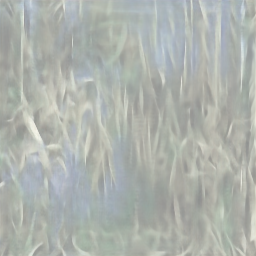

In [3]:

DEVICE = "cpu"

ALLOW_CUDA = True
ALLOW_MPS = False

if torch.cuda.is_available() and ALLOW_CUDA:
    DEVICE = "cuda"
elif (torch.has_mps or torch.backends.mps.is_available()) and ALLOW_MPS:
    DEVICE = "mps"
print(f"Using device: {DEVICE}")


diffusion,vae = load_models("checkpoints/diffusion/betaKL@1.0/diffusion_best_epoch4_loss0.0731.pt",
                             "checkpoints/vae/betaKL@1.0/weights_ck_398.pt",
                             DEVICE
                             )
vae.eval()
diffusion.eval()


models = {'diffusion':diffusion, 'vae':vae}
## SAMPLER

sampler = "ddpm"
num_inference_steps = 1000
seed = 42

output_image = pipeline.generate(
    sampler_name=sampler,
    n_inference_steps=num_inference_steps,
    seed=seed,
    models=models,
    device=DEVICE,
    idle_device="cpu"
)

# Combine the input image and the output image into a single image.
Image.fromarray(output_image)